In [76]:
import random
import numpy as np

In [77]:
def get_size_a():
    size_a = [14,100,40,4]
    return size_a
    
def get_size_b():
    size_b = [14]
    for i in range(6):
        size_b.append(28)
    size_b.append(4)
    return size_b

def get_size_c():
    size_c = [14]
    for i in range(28):
        size_c.append(14)
    size_c.append(4)
    return size_c

In [78]:
# eg. a_list[-1] = convert_to_hot_vector(np.argmax(a_list[-1]), 4)
def convert_to_hot_vector(y, num_class):
    v = np.zeros(num_class)
    v[y] = 1
    v.shape = (num_class,1)
    return v

# eg. convert_to_hot_vectors(np.array([1, 0, 3]), 4)
def convert_to_hot_vectors(y_s, num_class):
    m = np.zeros((y_s.size, num_class))
    m[np.arange(y_s.size), y_s] = 1
    return m

In [79]:
def relu(x):
    r = x * (x > 0)
    r.shape = x.shape
    return r.astype(np.float32)

def relu_derivative(x):
    x= x.astype(np.float32)
    d = np.array([1 if i > 0. else 0 for i in x]).astype(np.float32)
    d.shape = x.shape
    return d 

def softmax(x):
    """Compute softmax values for each value in x. Minus max to avoid large values in intermidiate steps"""
    e_x = np.exp(x - np.max(x)).astype(np.float32)
    return e_x / e_x.sum()

def cross_entropy(o,y):
    o = o.astype(np.float32)
    y = y.astype(np.float32)
    return -np.sum(np.multiply(y, np.log(o)))

test = np.arange(0,5)
print(test)
print(test.astype(np.float32))

[0 1 2 3 4]
[ 0.  1.  2.  3.  4.]


In [80]:
class Network(object):
    def __init__(self, sizes, initial_b=None, initial_w=None):
        self.num_layers = len(sizes)
        self.sizes = sizes
#         self.biases = initial_b if initial_b else [np.random.randn(y,1) for y in sizes[1:]]
#         self.weights = initial_w if initial_w else [np.random.randn(y,x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.biases = initial_b if initial_b else [np.random.random((y,1)) - 0.5 for y in sizes[1:]]
        self.weights = initial_w if initial_w else [np.random.random((y,x)) - 0.5 for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            a = relu(np.dot(w,a) + b)
        z = np.dot(self.weights[-1], a) + self.biases[-1]
        a = softmax(z)
        return a
    
    def stochastic_gradient_descent(self, training_data, iterations, mini_batch_size, learning_rate, test_data=None):
        """training_data is a list of tupes (x,y). ''test_data'' is used for cost & accuracy evaluation"""
        n = len(training_data)
        training_cost = np.zeros(iterations)
        test_cost = np.zeros(iterations)
        training_accuracy = np.zeros(iterations)
        test_accuracy = np.zeros(iterations)
        for i in range(iterations):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_weights_biases(mini_batch, learning_rate)
            # evaluate cost & accuracy for training data and test data
            training_cost[i], training_accuracy[i] = self.evaluate(training_data)
            print("Iter", i,": Training cost: ", training_cost[i], "; Training accuracy: ",training_accuracy[i])
            if test_data:
                test_cost[i], test_accuracy[i] = self.evaluate(test_data)
                print("Iter ", i,": Test cost: ", test_cost[i], "; Test accuracy: ", test_accuracy[i])
        return (training_cost, training_accuracy, test_cost, test_accuracy)
    
    def update_weights_biases(self, mini_batch, learning_rate):
        """The ``mini_batch`` is a list of tuples ``(x, y)``."""
        sum_gradients_b = [np.zeros(b.shape) for b in self.biases]
        sum_gradients_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            gradients_b, gradients_w = self.backpropagate(x, y)
            sum_gradients_b = [sum_gb + gb for sum_gb, gb in zip(sum_gradients_b, gradients_b)]
            sum_gradients_w = [sum_gw + gw for sum_gw, gw in zip(sum_gradients_w, gradients_w)]
        self.biases = [b - learning_rate/len(mini_batch)*gb for b, gb in zip(self.biases, sum_gradients_b)]
        self.weights = [w - learning_rate/len(mini_batch)*gw for w, gw in zip(self.weights, sum_gradients_w)]
    
    def backpropagate(self, x, y):
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        #feedforward
        a = x
        a_list = [x]
        z_list = []
        for b, w in zip(self.biases[0:-1], self.weights[0:-1]):
            z = np.dot(w, a) + b
            a = relu(z)
            a_list.append(a)
            z_list.append(z)
        z = np.dot(self.weights[-1], a_list[-1]) + self.biases[-1]
        a = softmax(z)
        a_list.append(a)
        z_list.append(z)
        # backward
        # for softmax-cross-entropy layer: delta in last layer = result - ground truth
        delta = a_list[-1] - y
        # update b and w for the last layer L
        gradients_b[-1] = delta
        gradients_w[-1] = np.dot(delta, a_list[-2].transpose())
        # update b and w for the rest of layers L-1, L-2, ... 
        for l in range(2, self.num_layers):
            z = z_list[-l]  # lth last layer of z
            r_derivative = relu_derivative(z)
            # update delta based on delta(l) = transpose of w(l+1) * delta(l+1)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * r_derivative
            gradients_b[-l] = delta
            gradients_w[-l] = np.dot(delta, a_list[-l-1].transpose())
        return (gradients_b, gradients_w)
    
    def evaluate(self, data):
        output = [self.feedforward(x) for x, y in data]
        cost = [cross_entropy(o, d[1]) for o, d in zip(output, data)]
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        accuracy = sum(int(x == y) for (x, y) in results)/len(results)
        avg_cost = sum(cost)/len(cost)
        return (avg_cost, accuracy)

    

In [81]:
from numpy import genfromtxt
import os

# prepare data
userhome = os.path.expanduser('~')
shared_path = userhome + r'/Downloads/assignment1/Question2_123'
path_training_x = 'x_train.csv'
path_training_y = 'y_train.csv'
path_test_x = 'x_test.csv'
path_test_y = 'y_test.csv'
training_X =  genfromtxt(os.path.join(shared_path, path_training_x),delimiter=",")
training_Y =  genfromtxt(os.path.join(shared_path, path_training_y),delimiter=",")
training_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(training_X,training_Y)]
test_X =  genfromtxt(os.path.join(shared_path, path_test_x),delimiter=",")
test_Y =  genfromtxt(os.path.join(shared_path, path_test_y),delimiter=",")
test_data = [(x.reshape(14,1), convert_to_hot_vector(int(y),4)) for x, y in zip(test_X, test_Y)]
# print(training_data[0][1].shape)

In [82]:
%matplotlib inline 
import matplotlib.pyplot as plt

def save_to_file(title, training_cost, training_accuracy, test_cost, test_accuracy):
    userhome = os.path.expanduser('~')
    path = userhome + r'/Downloads/e0047338/toDelete'
    filename = os.path.join(path, title + '.txt')
    np.savetxt(filename, (training_cost, training_accuracy,test_cost,test_accuracy), delimiter=',', fmt='%1.4f')
    
def plot_graph(title, y_1, y_2, size, label_1, label_2, x_label, y_label):
    plt.figure(figsize=(15,7))
    plt.title(title)
    plt.plot(np.arange(0, size, 1), y_1, 'o-', label = label_1)
    plt.plot(np.arange(0, size, 1), y_2, 'o-', label = label_2)
    plt.grid() 
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.legend(loc='best', fontsize=16)

network_b = Network(get_size_b())
training_cost, training_accuracy, test_cost, test_accuracy = network_b.stochastic_gradient_descent(training_data, 100, 100, 0.1, test_data)

Iter 0 : Training cost:  1.60377292777 ; Training accuracy:  0.323033493553
Iter  0 : Test cost:  1.61762296307 ; Test accuracy:  0.327738785475
Iter 1 : Training cost:  0.9137459902 ; Training accuracy:  0.564660105287
Iter  1 : Test cost:  0.942513538665 ; Test accuracy:  0.558132438206
Iter 2 : Training cost:  1.50082602045 ; Training accuracy:  0.428931105516
Iter  2 : Test cost:  1.5242414137 ; Test accuracy:  0.43240768996
Iter 3 : Training cost:  0.742398715216 ; Training accuracy:  0.676127260243
Iter  3 : Test cost:  0.774113944809 ; Test accuracy:  0.675007628929
Iter 4 : Training cost:  0.851686656312 ; Training accuracy:  0.684596017395
Iter  4 : Test cost:  0.890605344298 ; Test accuracy:  0.672566371681
Iter 5 : Training cost:  2.36758218765 ; Training accuracy:  0.484626535439
Iter  5 : Test cost:  2.42355309812 ; Test accuracy:  0.475434848947
Iter 6 : Training cost:  0.808489892456 ; Training accuracy:  0.679102769512
Iter  6 : Test cost:  0.870346222931 ; Test accurac

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Iter 30 : Training cost:  nan ; Training accuracy:  0.776607919432
Iter  30 : Test cost:  nan ; Test accuracy:  0.747940189197
Iter 31 : Training cost:  0.302146645567 ; Training accuracy:  0.875333791104
Iter  31 : Test cost:  0.361399340226 ; Test accuracy:  0.85657613671
Iter 32 : Training cost:  0.228885261543 ; Training accuracy:  0.906004425116
Iter  32 : Test cost:  0.3071802237 ; Test accuracy:  0.875190723222
Iter 33 : Training cost:  0.32021932586 ; Training accuracy:  0.877622644388
Iter  33 : Test cost:  0.401889923373 ; Test accuracy:  0.861153494049
Iter 34 : Training cost:  nan ; Training accuracy:  0.711757076371
Iter  34 : Test cost:  1.73816350969 ; Test accuracy:  0.697284101312
Iter 35 : Training cost:  0.36246314902 ; Training accuracy:  0.860608834974
Iter  35 : Test cost:  0.456343796852 ; Test accuracy:  0.839487335978
Iter 36 : Training cost:  0.170422375566 ; Training accuracy:  0.93057145037
Iter  36 : Test cost:  0.244073804421 ; Test accuracy:  0.9026548672

Iter 86 : Training cost:  nan ; Training accuracy:  0.949416342412
Iter  86 : Test cost:  0.242850333081 ; Test accuracy:  0.913030210558
Iter 87 : Training cost:  0.0557201888432 ; Training accuracy:  0.979476615549
Iter  87 : Test cost:  0.149127373176 ; Test accuracy:  0.943851083308
Iter 88 : Training cost:  0.638090275382 ; Training accuracy:  0.845349813077
Iter  88 : Test cost:  0.773155458087 ; Test accuracy:  0.819652120842
Iter 89 : Training cost:  0.266126522121 ; Training accuracy:  0.913710231174
Iter  89 : Test cost:  0.357333252173 ; Test accuracy:  0.886176380836
Iter 90 : Training cost:  0.290582875934 ; Training accuracy:  0.899748226139
Iter  90 : Test cost:  0.367362772178 ; Test accuracy:  0.877326823314
Iter 91 : Training cost:  0.220525627417 ; Training accuracy:  0.922178988327
Iter  91 : Test cost:  0.342914290628 ; Test accuracy:  0.897467195606
Iter 92 : Training cost:  0.0665581112725 ; Training accuracy:  0.97482261387
Iter  92 : Test cost:  0.160687043039 

In [83]:
save_to_file('14-28-6-4', training_cost, training_accuracy, test_cost, test_accuracy)

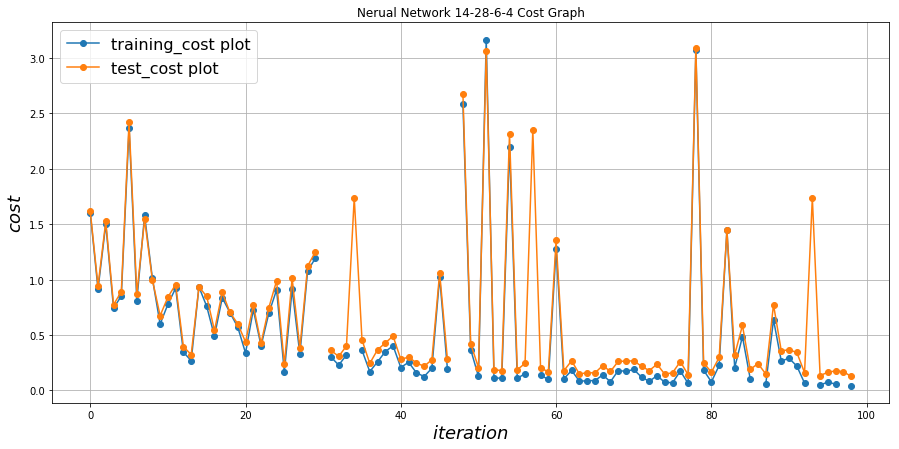

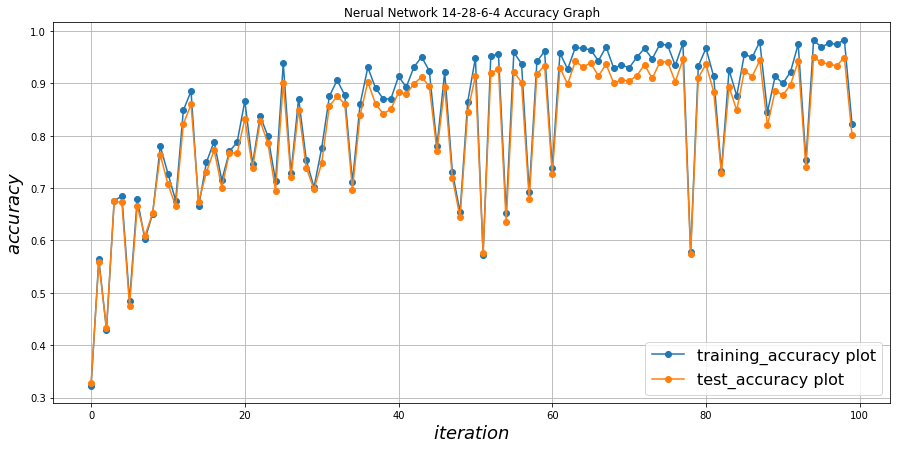

In [84]:
cost_title = 'Nerual Network 14-28-6-4 Cost Graph'
accuracy_title = 'Nerual Network 14-28-6-4 Accuracy Graph'
plot_graph(cost_title, training_cost, test_cost, training_cost.size, 'training_cost plot', 'test_cost plot', '$iteration$', '$cost$')
plot_graph(accuracy_title, training_accuracy, test_accuracy, training_accuracy.size, 'training_accuracy plot', 'test_accuracy plot', '$iteration$', '$accuracy$')

In [85]:
def check_shape(list_of_arrays):
    shapes = [b.shape for b in list_of_arrays]
    print(shapes)

In [86]:
# import csv
# import os

# x = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1])
# x.shape = (14,1)
# y = convert_to_hot_vector(3,4)
# y.shape = (4,1)

# userhome = os.path.expanduser('~')
# shared_path = userhome + r'/Downloads/assignment1/Question2_4/b'
# path_b_a = 'b-100-40-4.csv'
# path_w_a = 'w-100-40-4.csv'
# path_b_b = 'b-28-6-4.csv'
# path_w_b = 'w-28-6-4.csv'
# path_b_c = 'b-14-28-4.csv'
# path_w_c = 'w-14-28-4.csv'

# def output_gradient(x, y, sizes, shared_path, path_b, path_w):
#     biases = [np.zeros((y,1)) for y in sizes[1:]]
#     weights = [np.zeros((y,x)) for x, y in zip(sizes[:-1],sizes[1:])]
#     with open(os.path.join(shared_path,path_b), newline='') as file:
#         reader = csv.reader(file)
#         for row, i in zip(reader,range(len(biases))):
#             biases[i] = np.array([np.float32(v) for v in row[1:]])
#             biases[i].shape = (len(row[1:]),1)
#     with open(os.path.join(shared_path,path_w), newline='') as file:
#         reader = csv.reader(file)
#         indexes = [sum(sizes[0:i+1])  for i in range(len(sizes))]
#         index = 0
#         wts = [w.transpose() for w in weights]
#         for row, i in zip(reader,range(sum(sizes[:-1]))):
#             index = index + 1 if i >= indexes[index] else index
#             index_w = i - indexes[index-1] if index > 0 else i
#             wts[index][index_w] = [np.float32(v) for v in row[1:]]
#     weights = [wt.transpose() for wt in wts]      
#     network_a = Network(sizes, biases, weights)
#     gradients_b, gradients_w = network_a.backpropagate(x, y)
#     path_db = os.path.join(shared_path,'d'+path_b)
#     path_dw = os.path.join(shared_path,'d'+path_w)
#     with open(path_db, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gb in gradients_b:
#             n = [db[0] for db in gb]
#             writer.writerow(n)
#     with open(path_dw, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile, delimiter=',')
#         for gw in gradients_w:
#             dw = gw.transpose()
#             for row in dw:
#                 writer.writerow(row)
            

# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete c')

# shared_path = userhome + r'/Downloads/assignment1/Question2_4/c'
# output_gradient(x,y,get_size_a(),shared_path,path_b_a, path_w_a)
# print('complete test a')
# output_gradient(x,y,get_size_b(),shared_path,path_b_b, path_w_b)
# print('complete test b')
# output_gradient(x,y,get_size_c(),shared_path,path_b_c, path_w_c)
# print('complete test c')